In [1]:
import os
import sys
import csv
import h5py
import argparse
import numpy as np
from collections import Counter

# 3rd party imports
from sklearn import manifold
from keras.models import Model
from keras import backend as K
from IPython.display import Image

# ML4CVD Imports
from ml4cvd.defines import TENSOR_EXT
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from ml4cvd.models import make_multimodal_to_multilabel_model, train_model_from_generators, make_hidden_layer_model
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [40]:
gene2samples = {}
samples2genes = {}
tensor_path_prefix = '/mnt/disks/pix-size-tensors/2019-04-29/'
with open('/home/sam/genes_mri_ecg_carriers_sampleid.tsv', 'r') as my_tsv:
    lol = list(csv.reader(my_tsv, delimiter='\t'))
for row in lol[1:]:
    if row[0] == 'TTN':
        continue
    sample_list = [tensor_path_prefix + t + TENSOR_EXT for t in row[6].split(';')]
    gene2samples[row[0]] = sample_list
    for s in sample_list:
        samples2genes[s] = row[0]
[print(k, len(gene2samples[k])) for k in gene2samples]
gene_labels = ['TTN', 'AKAP9', 'DSC2', 'NEBL', 'RYR2', 'TRDN']


ABCC9 45
AKAP9 1593
ALMS1 231
ANK2 17
BAG3 5
CACNA1C 8
CALM1 1
CALM2 1
CALM3 1
CAV3 5
CSRP3 27
DSC2 1078
DSP 38
FKTN 35
GAA 72
GATA4 3
GLA 1
KCNE1 1
KCNE2 12
KCNH2 9
KCNJ2 1
KCNJ5 6
KCNQ1 20
LDB3 23
LMNA 7
MIB1 113
MYBPC3 19
MYH7 34
MYOM1 77
NEBL 319
NKX2-5 1
PKP2 48
RYR2 832
SCN4B 4
SCN5A 28
SLC22A5 41
SNTA1 13
TCAP 8
TRDN 372
TTR 1
TXNRD2 54


In [41]:
print(gene2samples['LMNA'])
gene2samples['TTN'] = []
with open('/home/sam/tranche01_hc_ttntv.csv', 'r') as my_tsv:
    lol = list(csv.reader(my_tsv, delimiter=','))
for row in lol[1:]:
    tp = tensor_path_prefix + row[0] + TENSOR_EXT
    gene2samples['TTN'].append(tp)
    samples2genes[tp] = 'TTN'
for k in gene2samples:
    print(k, len(gene2samples[k]))
print(gene2samples['TTN'])

['/mnt/disks/pix-size-tensors/2019-04-29/2958915.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/5091039.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/1873684.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/5072240.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/5926148.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/4276161.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/5619359.hd5']
ABCC9 45
AKAP9 1593
ALMS1 231
ANK2 17
BAG3 5
CACNA1C 8
CALM1 1
CALM2 1
CALM3 1
CAV3 5
CSRP3 27
DSC2 1078
DSP 38
FKTN 35
GAA 72
GATA4 3
GLA 1
KCNE1 1
KCNE2 12
KCNH2 9
KCNJ2 1
KCNJ5 6
KCNQ1 20
LDB3 23
LMNA 7
MIB1 113
MYBPC3 19
MYH7 34
MYOM1 77
NEBL 319
NKX2-5 1
PKP2 48
RYR2 832
SCN4B 4
SCN5A 28
SLC22A5 41
SNTA1 13
TCAP 8
TRDN 372
TTR 1
TXNRD2 54
TTN 227
['/mnt/disks/pix-size-tensors/2019-04-29/1129257.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/4460078.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/1385910.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/2080561.hd5', '/mnt/disks/pix-size-tensors/2019-04-29/2241529.hd

In [42]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole_weighted', 'mri_pixel_width', 'mri_pixel_height',
            '--output_tensors', 'mri_systole_diastole_segmented_weighted', 'end_systole_volume', 'end_diastole_volume',
                                 'ejection_fraction', 'lv_mass',
            '--batch_size', '4',
            '--pool_z', '1',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--u_connect',
            '--training_steps', '128',
            '--validation_steps', '6',
            '--test_steps', '6',
            '--model_file', '/home/sam/ml/trained_models/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef.hd5',
            '--id', 'mri_systole_diastole_unet_lv_mass_diseases']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                   args.tensor_maps_out,
                                                                                   args.tensors, 
                                                                                   args.batch_size,
                                                                                   args.valid_ratio,
                                                                                   args.test_ratio,
                                                                                   args.icd_csv,
                                                                                   args.balance_by_icds)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps*16)

2019-06-04 19:48:22,055 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_systole_diastole_unet_lv_mass_diseases/log_2019-06-04_19-48_0.log.
2019-06-04 19:48:22,057 - arguments:247 - INFO - Total TensorMaps:1249 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 28

2019-06-04 19:48:35,076 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 86, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['batch_index']] = tm.tensor_from_file(hd5)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 461, in tensor_from_file
    raise ValueError(self.name + ' is a continuous value that cannot be set to 0, but no value was found.')
ValueError: lv_mass is a continuous value that cannot be set to 0, but no value was found.


2019-06-04 19:48:35,093 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 80, in multimodal_multitask_generator
    in_batch[tm.input_name()][stats['batch_index']] = tm.tensor_f

In [43]:
gene2batch = {}
for g in gene2samples:
    gene_generator = TensorGenerator(args.batch_size, args.tensor_maps_in, args.tensor_maps_out, gene2samples[g], None, True)
    if g in gene_labels:
        gene2batch[g] = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out, gene_generator, args.test_steps) 

2019-06-04 19:49:09,742 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2006372.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,744 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,802 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5974763.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,817 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,840 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1575461.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,842 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,910 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2734382.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,911 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,955 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3130716.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,956 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,967 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3860415.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:09,968 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:09,994 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2495853.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,009 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,065 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3017171.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,066 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,126 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3957052.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,127 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,137 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5837314.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,139 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,195 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3959866.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,226 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,253 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4353527.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,254 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,303 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2227503.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,305 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,360 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3720256.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,362 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,430 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5648033.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,445 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,499 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2094600.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,500 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,542 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3144582.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,574 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,614 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4201177.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,616 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,657 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5225604.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,658 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,670 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4507835.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,671 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,767 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4365345.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,784 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,809 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3276617.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,810 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,849 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1621213.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,850 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,890 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5236441.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,891 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,949 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3561669.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:10,950 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:10,990 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2000786.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,005 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,044 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1257929.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,045 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,105 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2571155.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,106 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,118 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1516309.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,119 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,213 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1435325.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,261 - tensor_generators:227 - INFO - Input tens

2019-06-04 19:49:11,375 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2649325.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,376 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,387 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4237154.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,389 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,414 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3256198.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,416 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,469 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2627306.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,471 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,498 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3749136.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,500 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,576 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1188709.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,577 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,618 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1098971.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,635 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,660 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5059240.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,661 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,718 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3826143.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,719 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,759 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2903962.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,760 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,785 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1743425.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,787 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,831 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3592360.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,832 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,872 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5786549.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,889 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:11,933 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5185204.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:11,951 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,023 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4707499.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,025 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,064 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2599729.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,065 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,076 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4475487.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,077 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,088 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2032374.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,089 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,180 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5291349.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,181 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,206 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5235176.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,207 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,297 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5499426.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,298 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,325 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2127909.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,327 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,380 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1405415.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,381 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,512 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2401260.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,513 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,526 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4643419.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,528 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,555 - tensor_generators:350 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 86, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['batch_index']] = tm.tensor_from_file(hd5)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 461, in tensor_from_file
    raise ValueError(self.name + ' is a continuous value that cannot be set to 0, but no value was found.')
ValueError: lv_mass is a continuous value that cannot be set to 0, but no value was found.


2019-06-04 19:49:12,587 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6

2019-06-04 19:49:12,614 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3654846.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,629 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,667 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5905587.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,668 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,707 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3605034.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,710 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,762 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1992109.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,763 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,805 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5225727.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,807 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:12,862 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4463804.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,877 - tensor_generators:350 - INFO - Got first 


2019-06-04 19:49:12,947 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2985920.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:12,948 - tensor_generators:350 - INFO - Got first

2019-06-04 19:49:13,033 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1352800.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,034 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,074 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2316632.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,075 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,100 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1892142.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,117 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,176 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5441537.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,193 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,233 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5511804.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,235 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,306 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3026085.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,323 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,347 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1811427.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,348 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,376 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1028706.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,379 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,420 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1772970.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,422 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,511 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2732815.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,513 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,597 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4770942.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,599 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,609 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5132042.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,610 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,677 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4155354.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,680 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,706 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2750629.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,707 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,780 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3547698.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,781 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:13,835 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5745992.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:13,835 - tensor_generators:114 - INFO - OSError wh

2019-06-04 19:49:13,843 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5566807.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,844 - tensor_generators:114 - INFO - ValueError while attempt

2019-06-04 19:49:13,852 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4048504.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,853 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,862 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2435997.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,863 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,869 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1889597.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,870 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,878 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2190189.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,879 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,885 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2230913.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,886 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,895 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2319046.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,896 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,903 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1011183.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,904 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,910 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5059835.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,911 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,918 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3878391.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,919 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,925 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5740734.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,927 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,934 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4007216.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,934 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,941 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5104870.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,942 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,947 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3024530.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,948 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,956 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1556356.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,957 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,962 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2528381.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,964 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,970 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5256377.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,972 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,978 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2692080.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,979 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,985 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3158222.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,986 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:13,993 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/6014066.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:13,993 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,000 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1586788.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:14,001 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,007 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3797149.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:14,008 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,015 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3976331.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:14,016 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,022 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4126297.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:14,022 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,028 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3595410.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:14,029 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:14,236 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1270441.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,237 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,289 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5532611.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,291 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,330 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1062972.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,331 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,413 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3798615.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,414 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,506 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2183576.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,507 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,581 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3195841.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,583 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,622 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1506576.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,637 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,690 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4731713.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,692 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,747 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5620462.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,808 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,850 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3040665.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,851 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,924 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4859245.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,926 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:14,939 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2225693.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:14,941 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,012 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3317342.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,029 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,088 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5473653.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,105 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,130 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2779709.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,147 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,173 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3223822.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,189 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,214 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4560099.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,216 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,271 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5294778.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,294 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,324 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1757941.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,340 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,350 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1211854.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,352 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,379 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5784245.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,380 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,420 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2239780.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,422 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,462 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5415556.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,478 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,503 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2937220.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,505 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,545 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3669497.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,546 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,587 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5751693.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,588 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,613 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2788599.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,614 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,671 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1602076.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,673 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,698 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3371408.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,700 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,725 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3589592.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,726 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,759 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2405960.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,775 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,848 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1715537.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,849 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:15,874 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1876548.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:15,916 - tensor_generators:227 - INFO - Input tens

2019-06-04 19:49:16,039 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5576732.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,040 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,051 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1744558.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,051 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,062 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1098924.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,063 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,102 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2176585.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,103 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,157 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5654215.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,170 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,209 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1736197.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,210 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,298 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1054900.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,299 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,359 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4729844.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,361 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,372 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1295458.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,373 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,445 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5481424.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,446 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,575 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3996637.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,576 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,615 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2383192.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,616 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,679 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2878726.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,680 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,704 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3161224.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,706 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,731 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5047899.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,760 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,799 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2253565.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,800 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,825 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4208154.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,826 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,866 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3066310.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,867 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,879 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5235497.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,881 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,942 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1089640.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,944 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,956 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1250209.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,957 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:16,968 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4346748.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:16,986 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,057 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5938036.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,058 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,090 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2160996.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,091 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,118 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3825726.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,119 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,130 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4061228.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,131 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,218 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2118266.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,220 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,310 - tensor_generators:227 - INFO - Input tensor 'input_mri_systole_diastole' has shape (24, 256, 256, 2, 1)
2019-06-04 19:49:17,311 - tensor_generators:227 - INFO - Input tensor 'input_mri_pixel_width_continuous' has shape (24, 1)
2019-06-04 19:49:17,312 - tensor_generators:227 - INFO - Input tensor 'input_mri_pixel_height_continuous' has shape (24, 1)
2019-06-04 19:49:17,371 - tensor_generators:230 - INFO - Output tensor 'output_mri_systole_diastole_segmented_categorical' has shape (24, 256, 256, 2, 3)
2019-06-04 19:49:17,372 - tensor_generators:230 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (24, 1)
2019-06-04 19:49:17,373 - tensor_generators:230 - INFO - Output tensor 'output_end_diastole_volume_continuous' has shape (24, 1)
2019-06-04 19:49:17,374 - tensor_generators:230 - INFO - Output tensor 'output_ejection_fraction_continuous' has shape (24, 1)
2019-06-04 19:49:17,376 - tensor_generators:230 - INFO - Output tensor 'output_lv_mas

2019-06-04 19:49:17,410 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2753252.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,412 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,511 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3649183.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,512 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,623 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1016275.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,624 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,669 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4833248.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,671 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,716 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3075318.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,717 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,785 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3100203.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,786 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,841 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3521425.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,843 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,904 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1364546.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,905 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,917 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5506634.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,919 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:17,929 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2604100.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:17,931 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,023 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3293112.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,024 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,103 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4628503.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,105 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,116 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3601156.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,117 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,131 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1469593.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,132 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,180 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5869737.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,183 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,299 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5745519.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,300 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,346 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1295458.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,347 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,358 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1864753.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,359 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,381 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5310408.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,382 - tensor_generators:350 - INFO - Got first 

2019-06-04 19:49:18,405 - tensor_generators:350 - INFO - Got first error: OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4532959.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


2019-06-04 19:49:18,406 - tensor_generators:114 - INFO - OSError wh

2019-06-04 19:49:18,416 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3638804.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,417 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,425 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3503292.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,426 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,437 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4520849.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,438 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,446 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5657799.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,447 - tensor_generators:114 - INFO - ValueError while attempt

2019-06-04 19:49:18,454 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1321526.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,455 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,462 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2226662.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,463 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,470 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3809179.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,470 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,477 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5313393.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,478 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,485 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2190171.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,486 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,491 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3224537.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,493 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,500 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2836353.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,501 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,508 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1030750.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,509 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,515 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5026153.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,516 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,523 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1076222.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,523 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,531 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5635089.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,532 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,539 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5237958.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,540 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,546 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4091009.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,547 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,554 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4820456.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,555 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,561 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3421745.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 2
2019-06-04 19:49:18,563 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:18,569 - tensor_generators:114 - INFO - epochs: 1
2019-06-04 19:49:18,570 - tensor_generators:115 - INFO - Generator looped & shuffled over 227 tensors.
2019-06-04 19:49:18,571 - tensor_generators:116 - INFO - True epoch number:1 in which 9 tensors were presented.
2019-06-04 19:49:19,167 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.o

2019-06-04 19:49:19,175 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3638804.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,176 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,184 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3503292.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,185 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,194 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4520849.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,195 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,202 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5657799.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,202 - tensor_generators:114 - INFO - ValueError while attempt

2019-06-04 19:49:19,209 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1321526.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,210 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,215 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2226662.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,216 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,223 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3809179.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,225 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,229 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5313393.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,231 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,236 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2190171.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,237 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,245 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3224537.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,245 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,251 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/2836353.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,252 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,258 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1030750.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,258 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,265 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5026153.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,266 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,271 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/1076222.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,273 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,280 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5635089.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,281 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,287 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/5237958.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,288 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,294 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4091009.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,294 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,300 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/4820456.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,301 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,308 - tensor_generators:114 - INFO - OSError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 77, in multimodal_multitask_generator
    with h5py.File(tp, 'r') as hd5:
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 394, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/files.py", line 170, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 85, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = '/mnt/disks/pix-size-tensors/2019-04-29/3421745.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

: 3
2019-06-04 19:49:19,309 - tensor_generators:114 - INFO - OSError while attempting

2019-06-04 19:49:19,314 - tensor_generators:114 - INFO - epochs: 2
2019-06-04 19:49:19,315 - tensor_generators:115 - INFO - Generator looped & shuffled over 227 tensors.
2019-06-04 19:49:19,317 - tensor_generators:116 - INFO - True epoch number:2 in which 9 tensors were presented.
2019-06-04 19:49:19,732 - tensor_generators:227 - INFO - Input tensor 'input_mri_systole_diastole' has shape (24, 256, 256, 2, 1)
2019-06-04 19:49:19,733 - tensor_generators:227 - INFO - Input tensor 'input_mri_pixel_width_continuous' has shape (24, 1)
2019-06-04 19:49:19,734 - tensor_generators:227 - INFO - Input tensor 'input_mri_pixel_height_continuous' has shape (24, 1)
2019-06-04 19:49:19,798 - tensor_generators:230 - INFO - Output tensor 'output_mri_systole_diastole_segmented_categorical' has shape (24, 256, 256, 2, 3)
2019-06-04 19:49:19,799 - tensor_generators:230 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (24, 1)
2019-06-04 19:49:19,801 - tensor_generators:230 - INFO - Ou

In [44]:
for g in gene_labels:
    for k in test_data:
        test_data[k] = np.concatenate([test_data[k], gene2batch[g][0][k]])
    for k in test_labels:
        test_labels[k] = np.concatenate([test_labels[k], gene2batch[g][1][k]])    
    test_paths.extend(gene2batch[g][2])

In [45]:
layer_name = 'embed'
d1 = model.get_layer(layer_name)
w1 = d1.get_weights()
for w in w1:
    print(w.shape)
embed_model = make_hidden_layer_model(model, args.tensor_maps_in, layer_name)
embed_model.summary()
print(list(test_data.keys()))
x_embed = embed_model.predict(test_data, batch_size=args.batch_size)
predictions = model.predict(test_data, batch_size=args.batch_size)

(16, 64)
(64,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mri_systole_diastole (Inp (None, 256, 256, 2,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, 2,  608         input_mri_systole_diastole[0][0] 
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, 2,  18464       conv3d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling3d_1 (AveragePoo (None, 128, 128, 2,  0           conv3d_2[0][0]                   
______________________________________________________________________________________________

In [46]:
categorical_labels = [ 'Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0']
continuous_labels = ['22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']

label_dict = {k: np.zeros((len(test_paths))) for k in categorical_labels + continuous_labels + gene_labels}
for i, tp in enumerate(test_paths):
    hd5 = h5py.File(tp, 'r')
    #print(list(hd5['continuous'].keys()))
    for k in categorical_labels:
        if k in hd5['categorical']:
            label_dict[k][i] = 1
        elif k in hd5 and hd5[k][0] == 1:
            label_dict[k][i] = 1
    for mk in continuous_labels:
        for k in mk.split('|'):
            if k in hd5['continuous']:
                label_dict[mk][i] = hd5['continuous'][k][0]
    for k in gene_labels:
        if tp in samples2genes and samples2genes[tp] == k:
            label_dict[k][i] = 1
            
print(list(label_dict.keys()))
print(len(test_paths))

['Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0', '22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0', 'TTN', 'AKAP9', 'DSC2', 'NEBL', 'RYR2', 'TRDN']
528


process key: Genetic-sex_Female_0_0
process key: hypertension
process key: coronary_artery_disease
process key: Handedness-chiralitylaterality_Righthanded_0_0
process key: 22200_Year-of-birth_0_0|34_Year-of-birth_0_0
process key: 21001_Body-mass-index-BMI_0_0
process key: 1070_Time-spent-watching-television-TV_0_0
process key: 102_Pulse-rate-automated-reading_0_0
process key: 1488_Tea-intake_0_0
process key: 21002_Weight_0_0
process key: TTN
process key: AKAP9
process key: DSC2
process key: NEBL
process key: RYR2
process key: TRDN


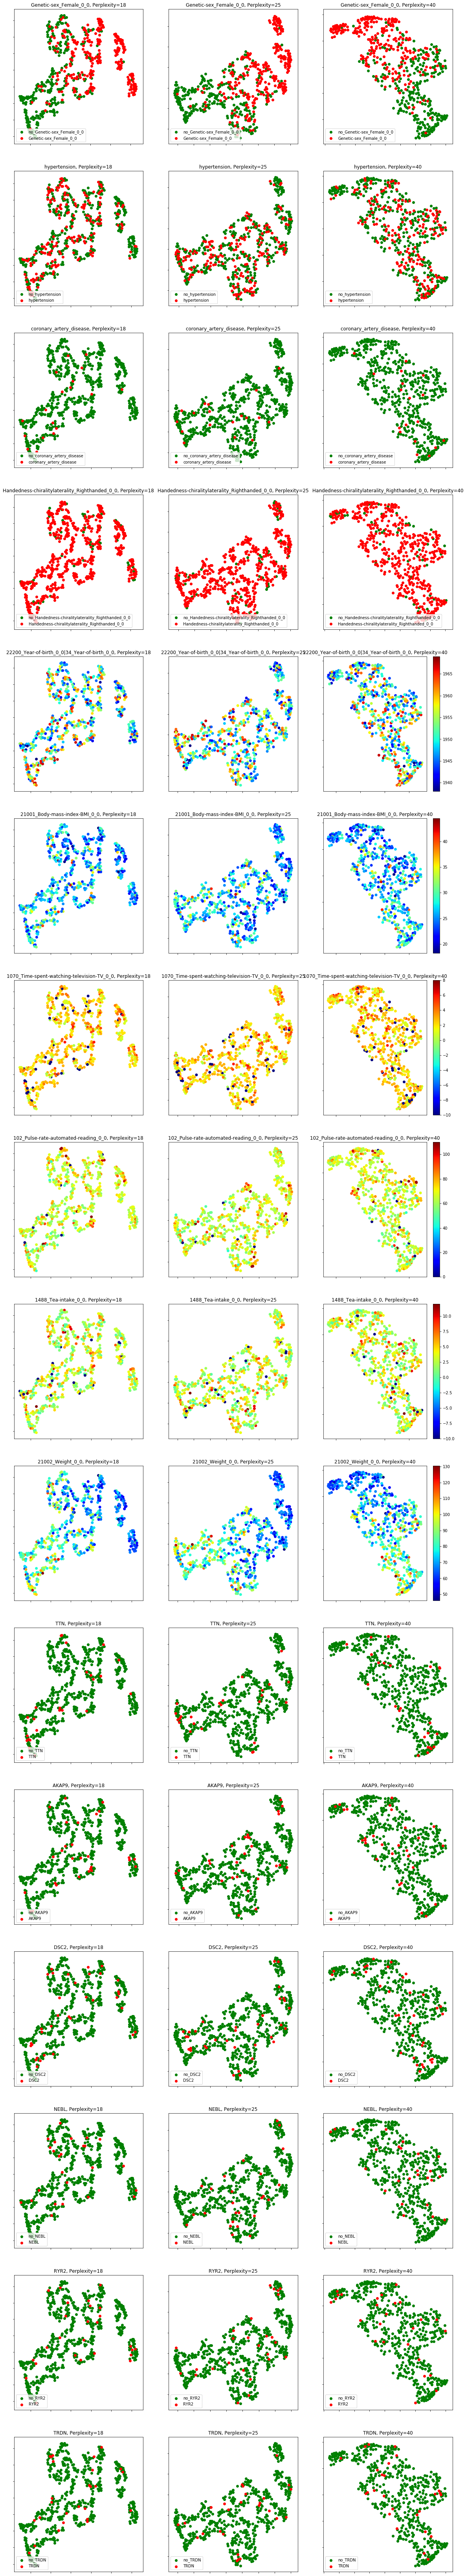

In [47]:
n_components = 2
max_rows = 30
(fig, subplots) = plt.subplots(min(max_rows, len(label_dict)), 3, figsize=(20, max_rows*4))
perplexities = [18, 25, 40]

p2y = {}
for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity, n_iter=5000)
    p2y[perplexity] = tsne.fit_transform(x_embed)

j = -1
for k in label_dict:
    j += 1
    if j == max_rows:
        break
    if k in categorical_labels+gene_labels:
        red = label_dict[k] == 1.0
        green = label_dict[k] != 1.0
    elif k in continuous_labels:
        colors = label_dict[k]      
        
    print('process key:', k)
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        ax.set_title(k+", Perplexity=%d" % perplexity)
        if k in categorical_labels+gene_labels:
            ax.scatter(p2y[perplexity][green, 0], p2y[perplexity][green, 1], c="g")
            ax.scatter(p2y[perplexity][red, 0], p2y[perplexity][red, 1], c="r")
            ax.legend(['no_'+k, k], loc='lower left')
        elif k in continuous_labels:
            points = ax.scatter(p2y[perplexity][:, 0], p2y[perplexity][:, 1], c=colors, cmap='jet') 
            if i == len(perplexities)-1:
                fig.colorbar(points, ax=ax)
                
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
plt.show()
